In [236]:
import os
import numpy as np
import pandas as pd
from skimage.transform import resize
from skimage.morphology import label
from skimage.morphology import binary_erosion
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scout import io
from scout import cyto
from scout import utils
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
working_dir = '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190430_11_36_09_AA-4.30.19-org1_488LP12p5_561LP120_642LP50'
os.listdir(working_dir)

['organoid_features.xlsx',
 'dataset',
 'individual_ventricle_cyto.xlsx',
 'cyto_labels.npy',
 'cyto_names.csv',
 'individual_ventricle_cellfreq.xlsx']

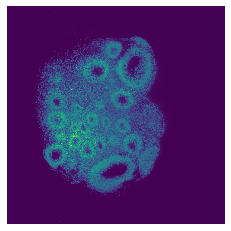

In [18]:
syto = io.imread(os.path.join(working_dir, 'dataset/syto_down6x.tif'))

plt.imshow(syto[len(syto)//2])
plt.axis('off')
plt.show()

In [43]:
downsample_factor = np.array([1, 6, 6])

voxel_orig = utils.read_voxel_size(os.path.join(working_dir, 'dataset/voxel_size.csv'))
print(f'Original voxel size: {voxel_orig}')

voxel_down = tuple(voxel_orig * downsample_factor)
print(f'Downsampled voxel size: {voxel_down}')

voxel_isotropic = tuple(max(voxel_down) * np.ones(len(voxel_down)))
print(f'Isotropic voxel size: {voxel_isotropic}')

Original voxel size: (2.0, 0.651, 0.651)
Downsampled voxel size: (2.0, 3.906, 3.906)
Isotropic voxel size: (3.906, 3.906, 3.906)


In [44]:
ventricles = io.imread(os.path.join(working_dir, 'dataset/segment_ventricles.tif'))
ventricles.shape

(900, 633, 633)

In [46]:
ventricles_smooth = cyto.smooth_segmentation(ventricles, sigma=2) > 0.5

In [49]:
factors = np.asarray(voxel_isotropic) / np.asarray(voxel_down)
shape_isotropic = tuple([int(s / f) for s, f in zip(ventricles_smooth.shape, factors)])
ventricles = resize(ventricles_smooth, output_shape=shape_isotropic, order=0, preserve_range=True)
ventricles.shape

(460, 633, 633)

In [51]:
ventricles = ventricles > 0

In [52]:
mesh = cyto.load_mesh(os.path.join(working_dir, 'dataset/mesh_ventricles.pkl'))
verts = mesh['verts']
verts.shape

(83151, 3)

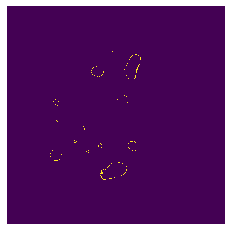

In [54]:
ventricles_eroded = binary_erosion(ventricles)
ventricles_surface = np.logical_and(ventricles, ~ventricles_eroded)

plt.figure()
plt.imshow(ventricles_surface[len(ventricles_surface)//2])
plt.axis('off')
plt.show()

In [55]:
surface_coords = np.asarray(np.where(ventricles_surface)).T
surface_coords.shape

(190375, 3)

In [69]:
surface_um = surface_coords * voxel_isotropic
surface_um.max(axis=0)

array([1203.048, 2019.402, 1898.316])

In [70]:
nbrs = NearestNeighbors(n_neighbors=1).fit(surface_um)
distances, indices = nbrs.kneighbors(verts)
indices.shape, verts.shape

((83151, 1), (83151, 3))

In [71]:
idx = indices[:, 0]
idx.shape

(83151,)

In [72]:
coords = surface_coords[idx]
coords.shape

(83151, 3)

In [73]:
coords_tuple = tuple([coords[:, i] for i in range(coords.shape[-1])])
coords_tuple

(array([ 40,  40,  40, ..., 308, 308, 307]),
 array([244, 244, 243, ..., 417, 416, 419]),
 array([366, 366, 367, ..., 245, 247, 244]))

In [74]:
labels = label(ventricles)
labels.shape, f'Found {labels.max()} ventricles'

((460, 633, 633), 'Found 139 ventricles')

In [75]:
ventricle_labels = labels[coords_tuple]
ventricle_labels.shape

(83151,)

ventricle labels represent the ventricle associated with each vertex. We can just bincount this

In [76]:
assert len(df) == labels.max()

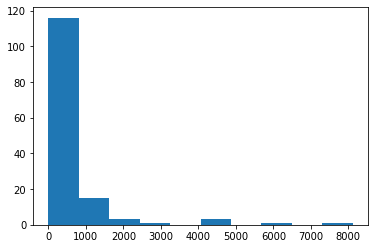

In [78]:
counts = np.bincount(ventricle_labels, minlength=labels.max())

plt.hist(counts)
plt.show()

In [98]:
df = pd.read_excel(os.path.join(working_dir, 'individual_ventricle_cellfreq.xlsx'), index_col=0)
df2 = pd.read_excel(os.path.join(working_dir, 'individual_ventricle_cyto.xlsx'), index_col=0)
df['dist'] = df2['dist']
df['dist_adj'] = df['dist'] - df['eq_diam'] / 2

df.head()

sox2_count  tbr1_count  dn_count  sox2_freq  tbr1_freq   dn_freq  \
0       24436      130823     68937   0.108994   0.583521  0.307485   
1        1009        5676      5524   0.082644   0.464903  0.452453   
2       78802     1253809    997987   0.033812   0.537977  0.428211   
3      164435      946349    733044   0.089181   0.513252  0.397566   
4       19803      112044    107598   0.082704   0.467932  0.449364   

      eq_diam        volume        dist    dist_adj  
0   93.816344  4.323487e+05  195.504012  148.595840  
1    4.846178  5.959320e+01   85.602234   83.179145  
2  254.819267  8.663540e+06  308.791898  181.382265  
3  247.764704  7.963737e+06  282.038282  158.155930  
4   69.361853  1.747273e+05  269.501738  234.820812

In [99]:
df['vertex count'] = counts[1:]
df.head()

sox2_count  tbr1_count  dn_count  sox2_freq  tbr1_freq   dn_freq  \
0       24436      130823     68937   0.108994   0.583521  0.307485   
1        1009        5676      5524   0.082644   0.464903  0.452453   
2       78802     1253809    997987   0.033812   0.537977  0.428211   
3      164435      946349    733044   0.089181   0.513252  0.397566   
4       19803      112044    107598   0.082704   0.467932  0.449364   

      eq_diam        volume        dist    dist_adj  vertex count  
0   93.816344  4.323487e+05  195.504012  148.595840           708  
1    4.846178  5.959320e+01   85.602234   83.179145            58  
2  254.819267  8.663540e+06  308.791898  181.382265          6340  
3  247.764704  7.963737e+06  282.038282  158.155930          4604  
4   69.361853  1.747273e+05  269.501738  234.820812           500

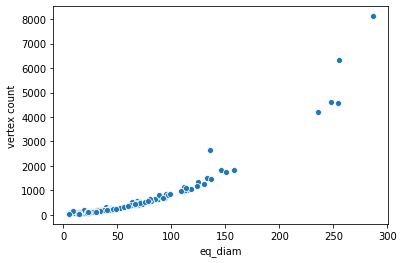

In [100]:
sns.scatterplot(x='eq_diam', y='vertex count', data=df)

In [119]:
df['surface area'] = 4 * np.pi * (df['eq_diam']/2/1000)**2

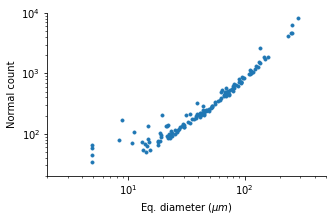

In [301]:
x = 4*np.pi*(df['eq_diam']/2)**2
y = df['vertex count']

mod = sm.OLS(y, x)
res = mod.fit()

display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           vertex count   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              5341.
Date:                Tue, 05 Nov 2019   Prob (F-statistic):                   3.30e-112
Time:                        11:00:07   Log-Likelihood:                         -931.75
No. Observations:                 139   AIC:                                      1865.
Df Residuals:                     138   BIC:                                      1868.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
eq_diam        0.0275      0.000     73.081      0.000       0.027       0.028
==============================================================================
Omnibus:                       56.370   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1786.831
Skew:                           0.573   Prob(JB):                         0.00
Kurtosis:                      20.527   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [303]:
res.params*1000**2  # normals/mm2

eq_diam    27514.105033
dtype: float64

In [313]:
res.bse * 1000**2

eq_diam    376.488628
dtype: float64

In [293]:
np.pi * (50/2)**2

1963.4954084936207

In [287]:
prstd, iv_l, iv_u = wls_prediction_std(res)

prstd.shape, iv_l.shape

((139,), (139,))

In [283]:
# x_model = np.logspace(0.1, 1**5)
y_model = res.params['eq_diam'] * df['eq_diam']**2 #+ res.params['const']
# y_model = np.exp(logy_model)

y_low = iv_l
y_high = iv_u

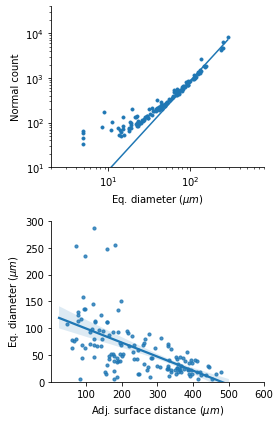

In [299]:
fig, ax = plt.subplots(nrows=2, figsize=(4, 6))

sns.scatterplot(x='eq_diam', y='vertex count', data=df, s=10, markers='.', edgecolor=None, ax=ax[0])
sns.lineplot(x=df['eq_diam'], y=y_model, ax=ax[0])
# sns.lineplot(x=df['eq_diam'], y=y_low, ax=ax[0])
# sns.lineplot(x=df['eq_diam'], y=y_high, ax=ax[0])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim([10, 4*10**4])
ax[0].set_xlim([2, 800])
ax[0].set_xlabel('Eq. diameter ($\mu m$)')
ax[0].set_ylabel('Normal count')
sns.despine()

sns.regplot(x='dist_adj', y='eq_diam', data=df, scatter_kws={'s': 10}, ax=ax[1])
ax[1].set_ylim([0, 300])
ax[1].set_xlim([2, 600])
ax[1].set_xlabel('Adj. surface distance ($\mu m$)')
ax[1].set_ylabel('Eq. diameter ($\mu m$)')
sns.despine()

plt.tight_layout()

plt.savefig(os.path.join(working_dir, 'ventricle_normal_density.pdf'), bbox_inches='tight')

plt.show()